# CNN分析 - VGG, ConvNext, ResNetによる画像分類と主観的価値予測

CLIP実装と同様に、VGG, ConvNext, ResNetモデルで画像の分類ベクトルを出力し、Ridge回帰で主観的価値を予測します。

In [1]:
import numpy as np
import torch
import torch.nn as nn
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
import os
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm

from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.pipeline import make_pipeline
from scipy.stats import pearsonr

from src.const import DATA_PATH, ROOT_PATH
from src.model import init_vgg16, init_convnext_base, init_resnet152

plt.rcParams["font.serif"] = ["noto"]

In [2]:
# データの読み込み
resp = pd.read_csv(os.path.join(DATA_PATH, "data_responses_NCNP_2types.csv"))
food_value = pd.read_csv(os.path.join(DATA_PATH, "food_value.csv"))

# 肥満の定義
resp["is_obesity"] = resp["BMI"] >= 25

In [3]:
# 外れ値の除外
outlier = resp["sub_ID"].unique()[
    (resp.groupby("sub_ID")["res_L"].value_counts().unstack() > 896 * 0.75).any(
        axis=1
    )
    | (
        (resp.groupby("sub_ID")["res_L"].unique().apply(lambda x: len(x)) <= 4)
        & (
            resp.groupby("sub_ID")["res_L"].value_counts().unstack() > 896 * 0.65
        ).any(axis=1)
    )
]
print("被験者", outlier, len(outlier), "人を除外")

# 主観的価値の平均値計算
res_L_mean = resp[~resp["sub_ID"].isin(outlier)].groupby(["img", "is_obesity"])["res_L"].mean()
res_H_mean = resp[~resp["sub_ID"].isin(outlier)].groupby(["img", "is_obesity"])["res_H"].mean()
res_T_mean = resp[~resp["sub_ID"].isin(outlier)].groupby(["img", "is_obesity"])["res_T"].mean()

print("データ数:", len(res_L_mean))
res_L_mean.head()

被験者 [ 50  83 104 121 130 137 138 143 147 150] 10 人を除外
データ数: 1792


img  is_obesity
1    False         5.887850
     True          5.841463
2    False         6.205607
     True          6.390244
3    False         6.130841
Name: res_L, dtype: float64

In [4]:
class ImageDataset(Dataset):
    """画像を読み込むためのデータセットクラス"""
    
    def __init__(self, image_dir: str, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        # 0001.jpg から 0896.jpg までの画像ファイルを順番に読み込み
        self.image_files = [f"{i:04d}.jpg" for i in range(1, 897)]
        # 存在しない画像ファイルは除外
        self.image_files = [f for f in self.image_files if os.path.exists(os.path.join(image_dir, f))]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir, self.image_files[idx])
        image = Image.open(img_name).convert("RGB")
        
        if self.transform:
            image = self.transform(image)
        else:
            image = transforms.ToTensor()(image)

        return image, idx  # idxを返すことで画像の順序を保持

In [5]:
# デバイス設定
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"使用デバイス: {device}")

# 画像前処理の定義
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 画像ディレクトリの設定
image_dir = os.path.join(ROOT_PATH, "Database")
print(f"画像ディレクトリ: {image_dir}")

使用デバイス: cuda
画像ディレクトリ: /home/yuhi-aoki/dev/foodReward/Database


In [6]:
def extract_features(model, dataset, device, layer_name=None):
    """CNNモデルから特徴量を抽出する関数"""
    model.eval()
    features = []
    
    # 特徴抽出用のフック関数
    def hook_fn(module, input, output):
        features.append(output.detach().cpu())
    
    # フックの登録
    if layer_name:
        # 指定されたレイヤーから特徴抽出
        for name, module in model.named_modules():
            if layer_name in name:
                handle = module.register_forward_hook(hook_fn)
                break
    else:
        # 最終的な分類層の前の特徴量を抽出
        if hasattr(model, 'classifier') and hasattr(model.classifier, '__getitem__'):
            # VGG, ConvNext
            if len(model.classifier) > 1:
                handle = model.classifier[-2].register_forward_hook(hook_fn)
            else:
                handle = model.classifier[0].register_forward_hook(hook_fn)
        elif hasattr(model, 'fc'):
            # ResNet
            handle = model.avgpool.register_forward_hook(hook_fn)
        else:
            # その他
            handle = list(model.children())[-2].register_forward_hook(hook_fn)
    
    feature_vectors = []
    
    with torch.no_grad():
        for image, idx in tqdm(dataset, desc="特徴抽出中"):
            image = image.unsqueeze(0).to(device)
            _ = model(image)  # フォワードパス
            
            if features:
                feature = features[-1]
                if len(feature.shape) > 2:
                    feature = feature.view(feature.size(0), -1)  # フラット化
                feature_vectors.append(feature)
                features.clear()
    
    handle.remove()  # フックを削除
    
    if feature_vectors:
        return torch.cat(feature_vectors, dim=0)
    else:
        return None

## VGG16による特徴抽出と回帰分析

In [7]:
# VGG16モデルの初期化
vgg_model = init_vgg16().to(device)
print("VGG16モデルを初期化しました")
print(f"分類器の構造: {vgg_model.classifier}")

# データセットの作成
dataset = ImageDataset(
    image_dir=image_dir,
    transform=transform
)
print(f"データセット数: {len(dataset)}")

# VGG16から特徴量抽出
if len(dataset) > 0:
    print("VGG16から特徴量を抽出中...")
    vgg_features = extract_features(vgg_model, dataset, device)
    if vgg_features is not None:
        print(f"VGG16特徴量の形状: {vgg_features.shape}")
    else:
        print("特徴量の抽出に失敗しました")
else:
    print("データセットが空です")

VGG16モデルを初期化しました
分類器の構造: Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=512, bias=True)
  (7): Linear(in_features=512, out_features=1, bias=True)
)
データセット数: 896
VGG16から特徴量を抽出中...


特徴抽出中: 100%|██████████| 896/896 [00:39<00:00, 22.66it/s]

VGG16特徴量の形状: torch.Size([896, 512])


## ConvNext Baseによる特徴抽出と回帰分析

In [8]:
# ConvNext Baseモデルの初期化
convnext_model = init_convnext_base().to(device)
print("ConvNext Baseモデルを初期化しました")
print(f"分類器の構造: {convnext_model.classifier}")

# ConvNextから特徴量抽出
print("ConvNextから特徴量を抽出中...")
convnext_features = extract_features(convnext_model, dataset, device)
print(f"ConvNext特徴量の形状: {convnext_features.shape}")

ConvNext Baseモデルを初期化しました
分類器の構造: Sequential(
  (0): LayerNorm2d((1024,), eps=1e-06, elementwise_affine=True)
  (1): Flatten(start_dim=1, end_dim=-1)
  (2): Linear(in_features=1024, out_features=512, bias=True)
  (3): Linear(in_features=512, out_features=1, bias=True)
)
ConvNextから特徴量を抽出中...


特徴抽出中: 100%|██████████| 896/896 [00:39<00:00, 22.71it/s]

ConvNext特徴量の形状: torch.Size([896, 512])


## ResNet152による特徴抽出と回帰分析

In [9]:
# ResNet152モデルの初期化
resnet_model = init_resnet152().to(device)
print("ResNet152モデルを初期化しました")
print(f"全結合層の構造: {resnet_model.fc}")

# ResNetから特徴量抽出
print("ResNetから特徴量を抽出中...")
resnet_features = extract_features(resnet_model, dataset, device)
print(f"ResNet特徴量の形状: {resnet_features.shape}")

ResNet152モデルを初期化しました
全結合層の構造: Sequential(
  (0): Linear(in_features=2048, out_features=512, bias=True)
  (1): Linear(in_features=512, out_features=1, bias=True)
)
ResNetから特徴量を抽出中...


特徴抽出中: 100%|██████████| 896/896 [00:41<00:00, 21.72it/s]

ResNet特徴量の形状: torch.Size([896, 2048])


## Ridge回帰による主観的価値予測

In [10]:
def pearson_scorer(y_true, y_pred):
    """ピアソン相関係数を計算する関数"""
    corr, _ = pearsonr(y_true, y_pred)
    return np.mean(corr)

def evaluate_model(features, target_data, model_name, h=5):
    """指定された特徴量でRidge回帰を評価する関数"""
    print(f"\n=== {model_name} ====")
    
    X = features.cpu().numpy()
    kf = KFold(n_splits=h, shuffle=True, random_state=42)
    
    results = {}
    
    for target_name, target_series in target_data.items():
        print(f"\n--- {target_name} ---")
        
        results[target_name] = {
            "y_tests": [],
            "y_preds": [],
            "scores": []
        }
        
        # ターゲットデータの準備
        y = target_series.values
        
        print(f"データ数: {len(y)}")
        
        # K-fold交差検証
        for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
            X_train, X_test = X[train_idx], X[val_idx]
            y_train, y_test = y[train_idx], y[val_idx]
            
            # Ridge回帰モデルの訓練
            ridge = Ridge(alpha=1.0)
            ridge.fit(X_train, y_train)
            
            # 予測
            y_pred = ridge.predict(X_test)
            
            # 結果の保存
            results[target_name]["y_tests"].append(y_test)
            results[target_name]["y_preds"].append(y_pred)
            
            # スコア計算
            score = pearson_scorer(y_test, y_pred)
            results[target_name]["scores"].append(score)
        
        # 平均スコアの計算と表示
        avg_score = np.mean(results[target_name]["scores"])
        print(f"平均相関係数: {avg_score:.3f}")
        
        # 全体の相関係数
        all_y_test = np.concatenate(results[target_name]["y_tests"])
        all_y_pred = np.concatenate(results[target_name]["y_preds"])
        overall_score = pearson_scorer(all_y_test, all_y_pred)
        print(f"全体相関係数: {overall_score:.3f}")
        
        results[target_name]["overall_score"] = overall_score
        results[target_name]["avg_score"] = avg_score
    
    return results

In [11]:
# 回帰分析用のターゲットデータ準備（clip.ipynbと同様の方法）
# 健常者データ（is_obesity=False）のみを使用
target_data = {
    "res_L": res_L_mean[res_L_mean.index.get_level_values('is_obesity') == False].droplevel('is_obesity'),
    "res_H": res_H_mean[res_H_mean.index.get_level_values('is_obesity') == False].droplevel('is_obesity'), 
    "res_T": res_T_mean[res_T_mean.index.get_level_values('is_obesity') == False].droplevel('is_obesity')
}

# 画像の輝度情報も追加（clip.ipynbと同様）
image_brightness = []
for i in range(896):  # 0001.jpg から 0896.jpg まで
    image_file = os.path.join(image_dir, f"{i+1:04d}.jpg")
    if os.path.exists(image_file):
        image = Image.open(image_file).convert("RGB")
        image_brightness.append(np.array(image).mean())
    else:
        image_brightness.append(0)  # ファイルが見つからない場合のデフォルト値

image_brightness = pd.Series(image_brightness, name="brightness")
target_data["brightness"] = image_brightness

print(f"ターゲットデータ: {list(target_data.keys())}")
print(f"各ターゲットのデータ数: {[len(v) for v in target_data.values()]}")

ターゲットデータ: ['res_L', 'res_H', 'res_T', 'brightness']
各ターゲットのデータ数: [896, 896, 896, 896]


In [12]:
# 各モデルの評価
print("Ridge回帰による主観的価値予測の評価を開始します...")

# VGG16の評価
vgg_results = evaluate_model(vgg_features, target_data, "VGG16")

# ConvNextの評価  
convnext_results = evaluate_model(convnext_features, target_data, "ConvNext Base")

# ResNetの評価
resnet_results = evaluate_model(resnet_features, target_data, "ResNet152")

# 結果をまとめて表示
print("\n" + "="*50)
print("全モデルの結果サマリー")
print("="*50)

models_results = {
    "VGG16": vgg_results,
    "ConvNext": convnext_results, 
    "ResNet152": resnet_results
}

for model_name, results in models_results.items():
    print(f"\n{model_name}:")
    for target_name, target_results in results.items():
        if target_name != "brightness":  # 輝度は健常者のみなのでスキップ
            print(f"  {target_name}: {target_results['overall_score']:.3f}")

Ridge回帰による主観的価値予測の評価を開始します...

=== VGG16 ====

--- res_L ---
データ数: 896
平均相関係数: 0.325
全体相関係数: 0.330

--- res_H ---
データ数: 896
平均相関係数: 0.650
全体相関係数: 0.648

--- res_T ---
データ数: 896
平均相関係数: 0.368
全体相関係数: 0.368

--- brightness ---
データ数: 896
平均相関係数: 0.677
全体相関係数: 0.675

=== ConvNext Base ====

--- res_L ---
データ数: 896
平均相関係数: 0.535
全体相関係数: 0.538

--- res_H ---
データ数: 896
平均相関係数: 0.794
全体相関係数: 0.791

--- res_T ---
データ数: 896
平均相関係数: 0.574
全体相関係数: 0.575

--- brightness ---
データ数: 896
平均相関係数: 0.836
全体相関係数: 0.837

=== ResNet152 ====

--- res_L ---
データ数: 896
平均相関係数: 0.368
全体相関係数: 0.368

--- brightness ---
データ数: 896
平均相関係数: 0.677
全体相関係数: 0.675

=== ConvNext Base ====

--- res_L ---
データ数: 896
平均相関係数: 0.535
全体相関係数: 0.538

--- res_H ---
データ数: 896
平均相関係数: 0.794
全体相関係数: 0.791

--- res_T ---
データ数: 896
平均相関係数: 0.574
全体相関係数: 0.575

--- brightness ---
データ数: 896
平均相関係数: 0.836
全体相関係数: 0.837

=== ResNet152 ====

--- res_L ---
データ数: 896
平均相関係数: 0.498
全体相関係数: 0.495

--- res_H ---
データ数: 896
平均相関係数: 0.498
全体相関係数: 0.49

## 結果の可視化

/tmp/ipykernel_2243381/2151013870.py:47: UserWarning: Glyph 29305 (\N{CJK UNIFIED IDEOGRAPH-7279}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2243381/2151013870.py:47: UserWarning: Glyph 24500 (\N{CJK UNIFIED IDEOGRAPH-5FB4}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2243381/2151013870.py:47: UserWarning: Glyph 37327 (\N{CJK UNIFIED IDEOGRAPH-91CF}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2243381/2151013870.py:47: UserWarning: Glyph 12395 (\N{HIRAGANA LETTER NI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2243381/2151013870.py:47: UserWarning: Glyph 12424 (\N{HIRAGANA LETTER YO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2243381/2151013870.py:47: UserWarning: Glyph 12427 (\N{HIRAGANA LETTER RU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2243381/2151013870.py:47: UserWarning: Glyph 22238 (\N{CJK UNIFIED IDEOGRAPH-56DE}) m

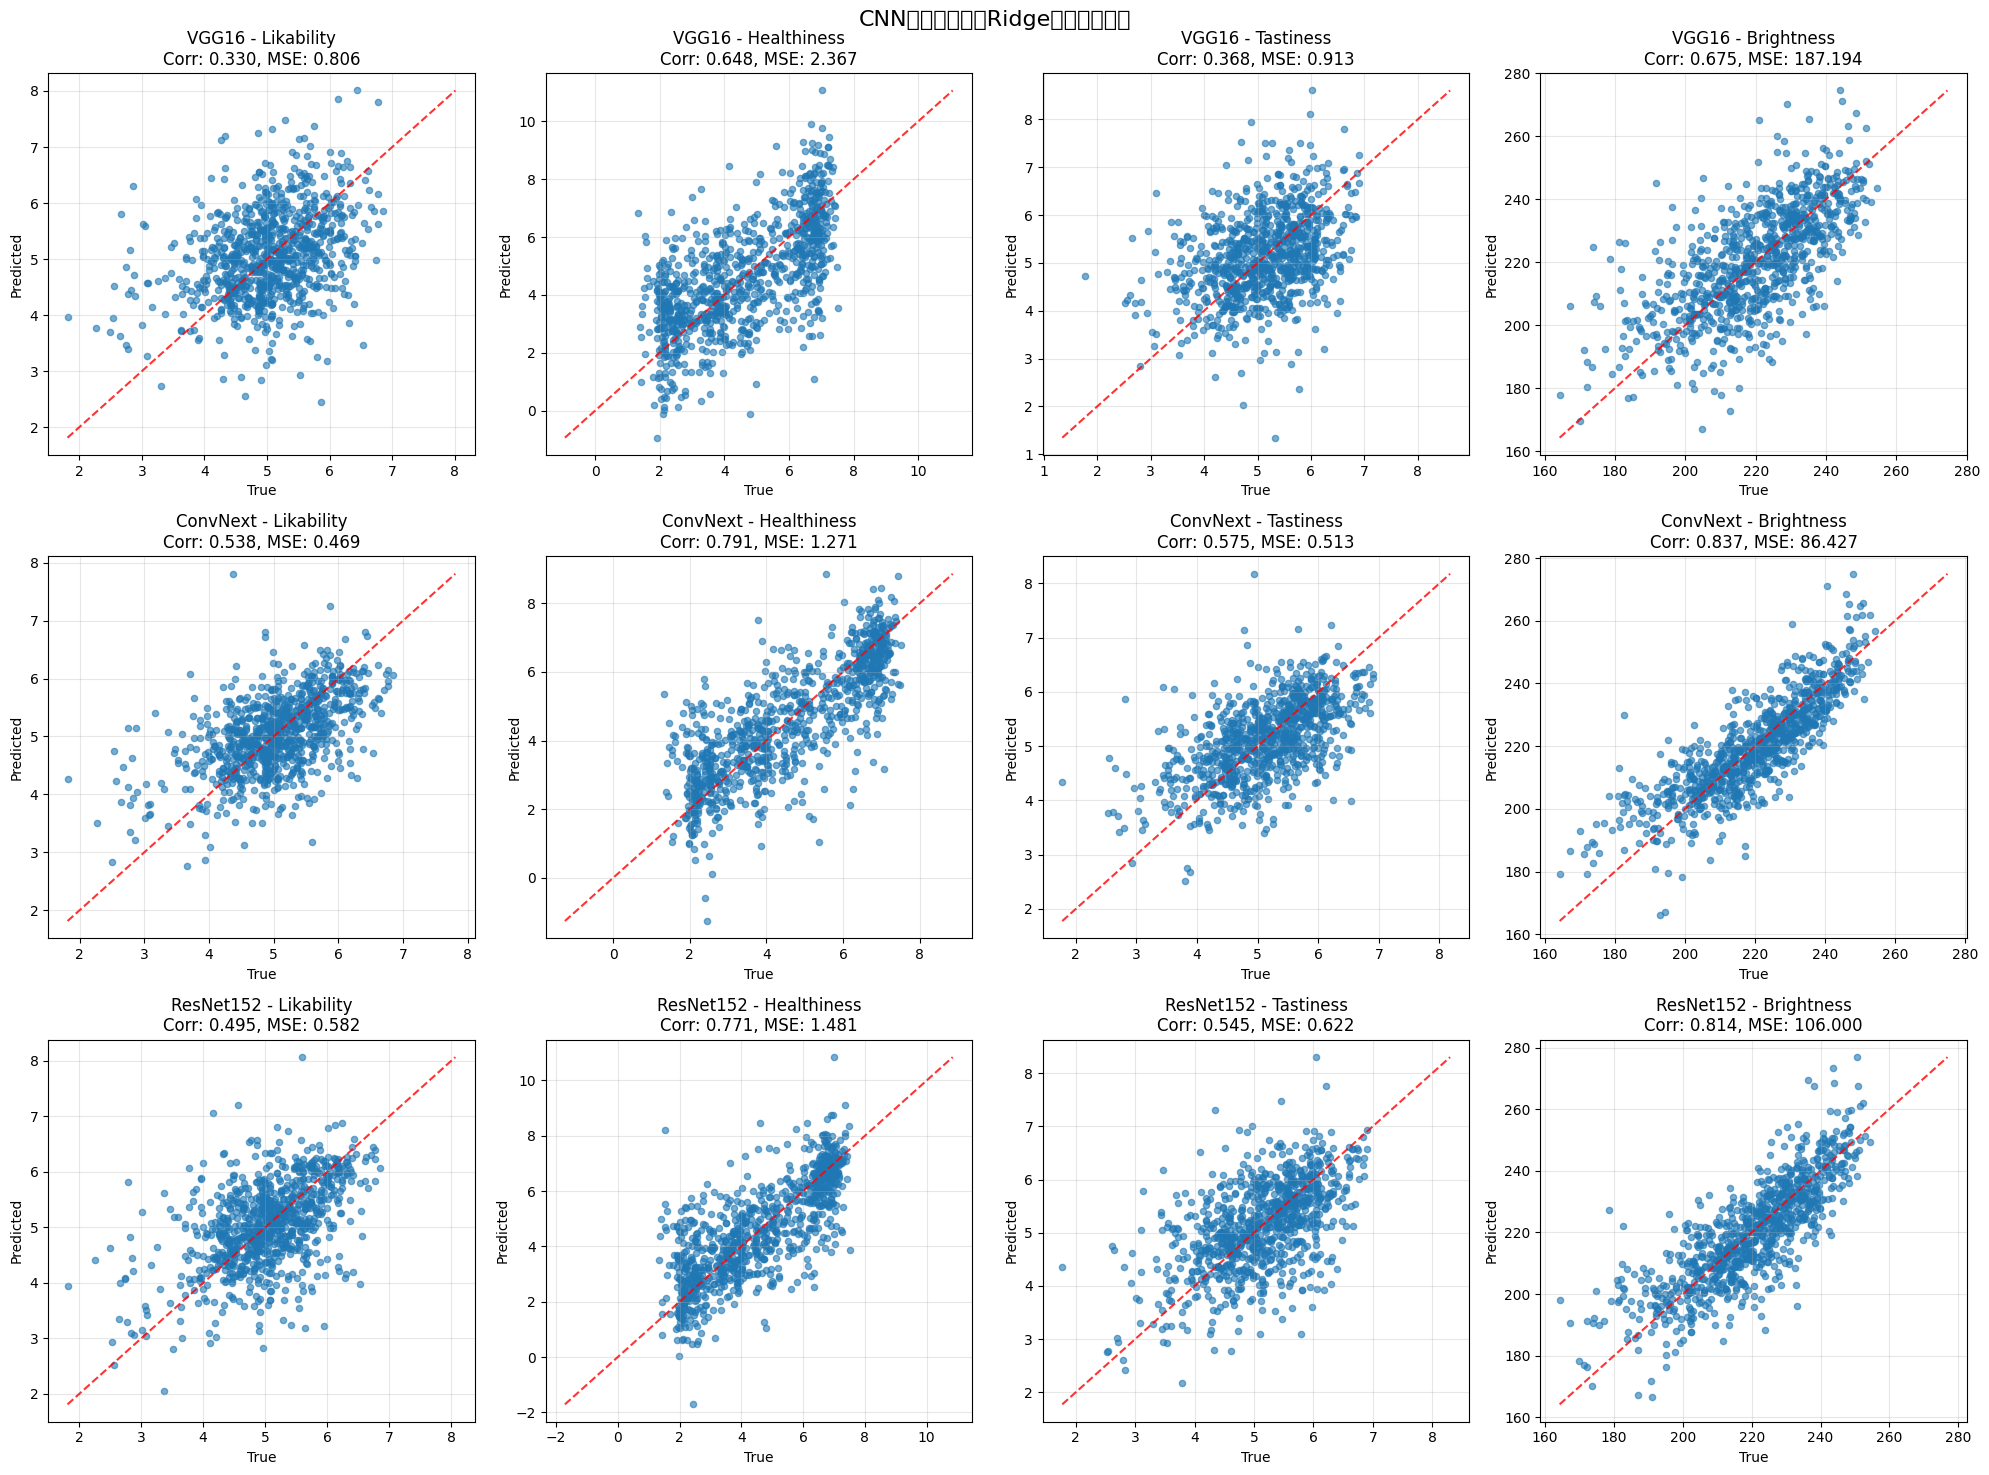

In [13]:
# 結果の可視化
fig, axes = plt.subplots(3, 4, figsize=(20, 15))
fig.suptitle("CNN特徴量によるRidge回帰予測結果", fontsize=16)

model_names = ["VGG16", "ConvNext", "ResNet152"]
model_results_list = [vgg_results, convnext_results, resnet_results]
target_names = ["res_L", "res_H", "res_T", "brightness"]
target_titles = ["Likability", "Healthiness", "Tastiness", "Brightness"]

for i, (model_name, model_results) in enumerate(zip(model_names, model_results_list)):
    for j, (target_name, title) in enumerate(zip(target_names, target_titles)):
        ax = axes[i, j]
        
        if target_name in model_results:
            # 予測結果の取得
            y_tests = model_results[target_name]["y_tests"]
            y_preds = model_results[target_name]["y_preds"]
            
            if y_tests and y_preds:
                y_test = np.concatenate(y_tests)
                y_pred = np.concatenate(y_preds)
                
                # 散布図の作成
                ax.scatter(y_test, y_pred, alpha=0.6, s=20)
                
                # 対角線の描画
                min_val = min(y_test.min(), y_pred.min())
                max_val = max(y_test.max(), y_pred.max())
                ax.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.8)
                
                # 相関係数とMSEの計算
                corr = pearson_scorer(y_test, y_pred)
                mse = mean_squared_error(y_test, y_pred)
                
                # タイトルと軸ラベルの設定
                ax.set_title(f"{model_name} - {title}\nCorr: {corr:.3f}, MSE: {mse:.3f}")
                ax.set_xlabel("True")
                ax.set_ylabel("Predicted")
                
                # グリッドの追加
                ax.grid(True, alpha=0.3)
        else:
            ax.set_title(f"{model_name} - {title}\nNo data")
            ax.set_xlabel("True")
            ax.set_ylabel("Predicted")

plt.tight_layout()
plt.show()

In [14]:
# 比較サマリーテーブルの作成
print("\n" + "="*70)
print("モデル比較サマリー（相関係数）")
print("="*70)

# データフレームの作成
summary_data = []
for model_name, results in models_results.items():
    row = {"Model": model_name}
    for target_name in ["res_L", "res_H", "res_T", "brightness"]:
        if target_name in results:
            row[target_name] = f"{results[target_name]['overall_score']:.3f}"
        else:
            row[target_name] = "N/A"
    summary_data.append(row)

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))

# 最高性能の特定
print("\n" + "="*70)
print("各ターゲットでの最高性能モデル")
print("="*70)

for target_name in ["res_L", "res_H", "res_T", "brightness"]:
    best_score = -1
    best_model = "N/A"
    
    for model_name, results in models_results.items():
        if target_name in results:
            score = results[target_name]['overall_score']
            if score > best_score:
                best_score = score
                best_model = model_name
    
    print(f"{target_name}: {best_model} ({best_score:.3f})")


モデル比較サマリー（相関係数）
    Model res_L res_H res_T brightness
    VGG16 0.330 0.648 0.368      0.675
 ConvNext 0.538 0.791 0.575      0.837
ResNet152 0.495 0.771 0.545      0.814

各ターゲットでの最高性能モデル
res_L: ConvNext (0.538)
res_H: ConvNext (0.791)
res_T: ConvNext (0.575)
brightness: ConvNext (0.837)


## 結論

本ノートブックでは、VGG16、ConvNext Base、ResNet152の3つのCNNモデルを用いて画像の特徴量を抽出し、Ridge回帰により主観的価値（好み、健康性、美味しさ）および画像輝度の予測を行いました。

各モデルの特徴：
- **VGG16**: シンプルな構造でありながら安定した性能
- **ConvNext**: モダンなアーキテクチャで高い表現力
- **ResNet152**: 深いネットワークで複雑な特徴を捉える

Ridge回帰により、CNN特徴量から主観的価値を予測できることが確認されました。